In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
from nltk.stem import WordNetLemmatizer

nltk.download('wordnet')

sns.set()

[nltk_data] Downloading package wordnet to /Users/jskaf/nltk_data...


In [20]:
#read json file in pandas

df = pd.read_json('data/airbus_helicopters_train_set.json')
df.head()

,train_sum01,train_sum010,train_sum0100,train_sum0101,train_sum0102,train_sum0103,train_sum0104,train_sum0105,train_sum0106,train_sum0107,...,train_sum090,train_sum091,train_sum092,train_sum093,train_sum094,train_sum095,train_sum096,train_sum097,train_sum098,train_sum099
original_text,These general Standard Conditions of Sale appl...,Each Party represents to the other as at the d...,"All living, travelling and accommodation expen...","Unless otherwise specified in the Contract, th...",Reasonable insurance coverage of risks arising...,Any change requested by the Customer shall be ...,"After receipt of the Order Confirmation, shoul...",The Training Services shall be performed in ac...,Should a trainee be late for or absent from an...,Changes to the training session planning reque...,...,These SCS along with the applicable Specific A...,In the event that one (1) or more of the artic...,English shall be the language of the Contract....,In case of any contradictions and discrepancie...,"The provisions of the confidentiality, intelle...",No term or provision hereof will be considered...,Any variation or modification of the Contract ...,The relationship between the Parties is solely...,"The Customer shall not be entitled, without th...","This Specific Annex, subject to SCS, is applic..."
reference_summary,These terms and conditions apply as soon as th...,Each Party represents that the other is not a ...,"Expenses relating to the travelling, living an...","Unless otherwise specified in the Contract, th...",Reasonable insurance coverage of risks arising...,All the changes requested by the Customer are ...,If the Customer decides to cancel a confirmed ...,The Training Services are performed depending ...,"If a trainee is late or absent from a course, ...",Changes to the training session planning must ...,...,These conditions supersede all previous commun...,If 1 or more articles of these conditions are ...,English is the language of the Contract and sh...,The order of precedence is the following : Pur...,"The provisions regarding confidentiality, IP, ...","No term, provision or breach shall be waived o...",Any modification to the contract shall be put ...,No joint venture or partnership is intended no...,Unless the Seller agrees to it through writing...,This annex is subject to the SCS and applies t...
uid,train_sum01,train_sum010,train_sum0100,train_sum0101,train_sum0102,train_sum0103,train_sum0104,train_sum0105,train_sum0106,train_sum0107,...,train_sum090,train_sum091,train_sum092,train_sum093,train_sum094,train_sum095,train_sum096,train_sum097,train_sum098,train_sum099


In [21]:
# transpose the dataframe

df = df.T
df.head()

,original_text,reference_summary,uid
train_sum01,These general Standard Conditions of Sale appl...,These terms and conditions apply as soon as th...,train_sum01
train_sum010,Each Party represents to the other as at the d...,Each Party represents that the other is not a ...,train_sum010
train_sum0100,"All living, travelling and accommodation expen...","Expenses relating to the travelling, living an...",train_sum0100
train_sum0101,"Unless otherwise specified in the Contract, th...","Unless otherwise specified in the Contract, th...",train_sum0101
train_sum0102,Reasonable insurance coverage of risks arising...,Reasonable insurance coverage of risks arising...,train_sum0102


In [22]:
#reset the index

df = df.reset_index()
df.drop('index', axis=1, inplace=True)
df.head()

,original_text,reference_summary,uid
0,These general Standard Conditions of Sale appl...,These terms and conditions apply as soon as th...,train_sum01
1,Each Party represents to the other as at the d...,Each Party represents that the other is not a ...,train_sum010
2,"All living, travelling and accommodation expen...","Expenses relating to the travelling, living an...",train_sum0100
3,"Unless otherwise specified in the Contract, th...","Unless otherwise specified in the Contract, th...",train_sum0101
4,Reasonable insurance coverage of risks arising...,Reasonable insurance coverage of risks arising...,train_sum0102


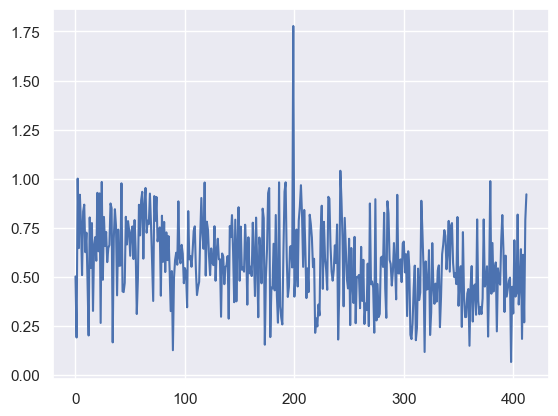

In [23]:
#plot the ration length of original_text / length of reference_summary

df['ratio'] =  df['reference_summary'].apply(lambda x: len(x)) / df['original_text'].apply(lambda x: len(x))
df.head()

plt.plot(df['ratio'])



In [24]:
temp = df[df['ratio'] > 0.9]
len(temp)

25

In [25]:
# Add a new column to the dataframe to store the length of the original text

df['length_original_text'] = df['original_text'].apply(lambda x: len(x))


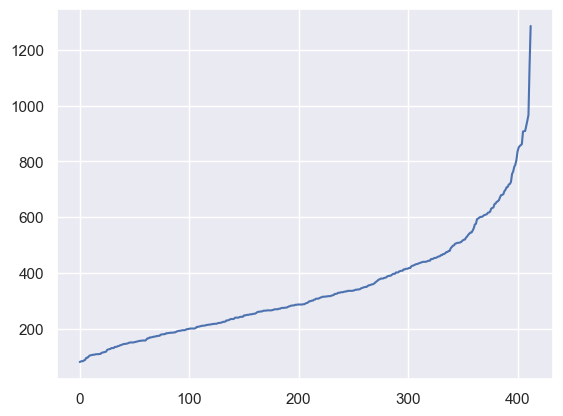

In [26]:
#Sort the dataframe by the length of the original text and plot the length of the original text

df = df.sort_values(by='length_original_text')
df.reset_index(inplace=True)
df.drop('index', axis=1, inplace=True)

plt.plot(df['length_original_text'])

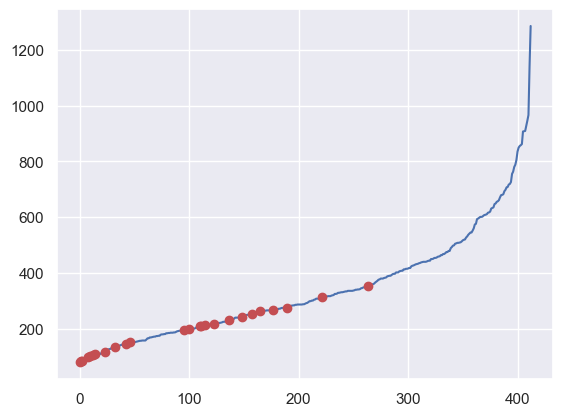

In [27]:
df["target"] = df["ratio"].apply(lambda x: 1 if x > 0.9 else 0)

# Plot the length of the original text, in red the rows with target = 1

plt.plot(df['length_original_text'])
plt.plot(df[df['target'] == 1]['length_original_text'], 'ro')


In [34]:
# Tokenize and preprocess
def preprocess(text):
    tokens = word_tokenize(text.lower())
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word.isalnum() and word not in stop_words]
    return tokens

In [35]:
def preprocess_lemma(text):
    tokens = word_tokenize(text.lower())
    stop_words = set(stopwords.words('english'))
    
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word.isalnum() and word not in stop_words]
    
    return tokens

In [36]:
# Build frequency dictionaries
entry_texts_freq = Counter()
summarizations_freq = Counter()

for entry_text, summarization in zip(df["original_text"], df["reference_summary"]):
    entry_texts_freq.update(preprocess(entry_text))
    summarizations_freq.update(preprocess(summarization))

# Calculate retention and erasure rates
retention_rates = {}
erasure_rates = {}

for word in entry_texts_freq:
    total_occurrences = entry_texts_freq[word]
    retention_rate = summarizations_freq[word] / total_occurrences if total_occurrences > 0 else 0
    erasure_rate = 1 - retention_rate
    retention_rates[word] = retention_rate
    erasure_rates[word] = erasure_rate

In [37]:
# Identify significant words (adjust thresholds as needed)
significant_words_kept = [word for word in retention_rates if retention_rates[word] > 0.8 and erasure_rates[word] < 0.2]
significant_words_erased = [word for word in retention_rates if retention_rates[word] < 0.2 and erasure_rates[word] > 0.8]

In [40]:
# Build frequency dictionaries
entry_texts_freq = Counter()
summarizations_freq = Counter()

for entry_text, summarization in zip(df["original_text"], df["reference_summary"]):
    entry_texts_freq.update(preprocess_lemma(entry_text))
    summarizations_freq.update(preprocess_lemma(summarization))

# Calculate retention and erasure rates
retention_rates_lemma = {}
erasure_rates_lemma = {}

for word in entry_texts_freq:
    total_occurrences = entry_texts_freq[word]
    retention_rate = summarizations_freq[word] / total_occurrences if total_occurrences > 0 else 0
    erasure_rate = 1 - retention_rate
    retention_rates_lemma[word] = retention_rate
    erasure_rates_lemma[word] = erasure_rate

In [41]:
significant_words_kept_lemma = [word for word in retention_rates_lemma if retention_rates_lemma[word] > 0.8 and erasure_rates_lemma[word] < 0.2]
significant_words_erased_lemma = [word for word in retention_rates_lemma if retention_rates_lemma[word] < 0.2 and erasure_rates_lemma[word] > 0.8]

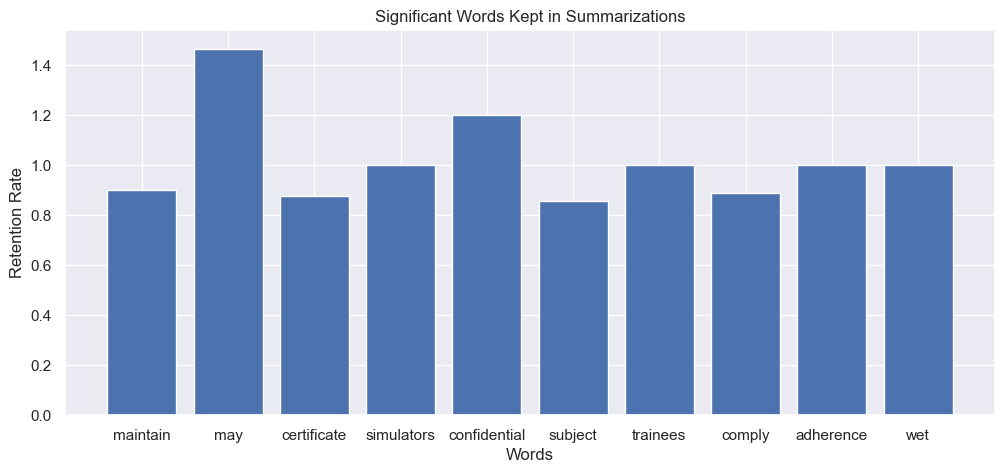

In [42]:
# Visualize the results
# (You can use matplotlib, seaborn, or any other plotting library)

# Example: Bar chart for significant words kept
plt.figure(figsize=(12, 5))

plt.bar(significant_words_kept[:10], [retention_rates[word] for word in significant_words_kept][:10])
plt.xlabel('Words')
plt.ylabel('Retention Rate')
plt.title('Significant Words Kept in Summarizations')
plt.show()

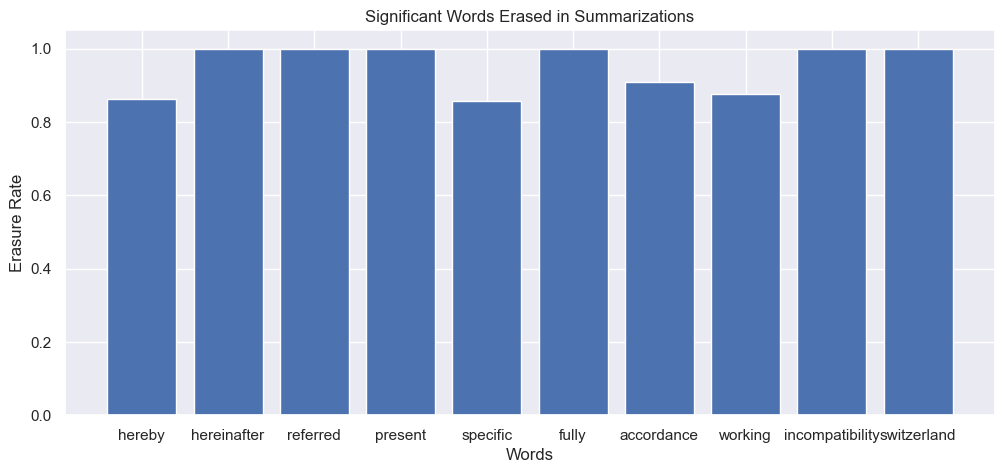

In [43]:
plt.figure(figsize=(12, 5))
# Example: Bar chart for significant words erased
plt.bar(significant_words_erased[:10], [erasure_rates[word] for word in significant_words_erased][:10])
plt.xlabel('Words')
plt.ylabel('Erasure Rate')
plt.title('Significant Words Erased in Summarizations')
plt.show()

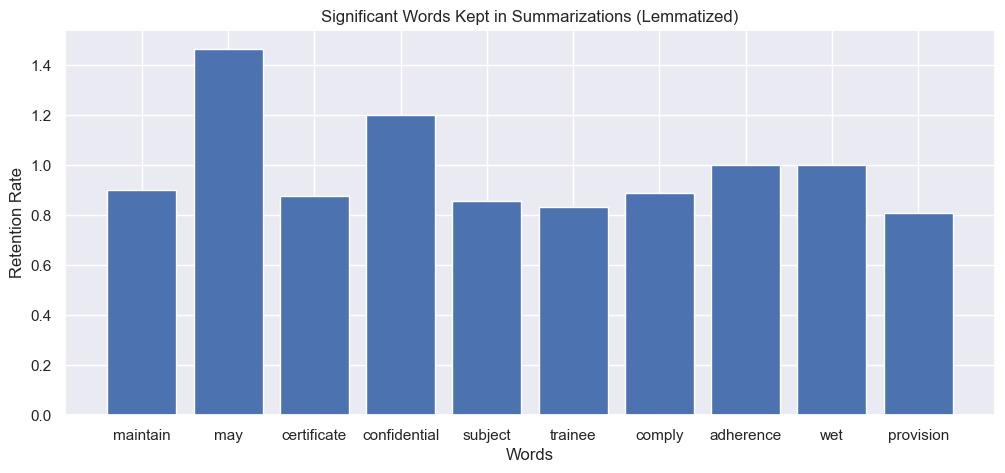

In [45]:
plt.figure(figsize=(12, 5))
plt.bar(significant_words_kept_lemma[:10], [retention_rates_lemma[word] for word in significant_words_kept_lemma][:10])
plt.xlabel('Words')
plt.ylabel('Retention Rate')
plt.title('Significant Words Kept in Summarizations (Lemmatized)')
plt.show()

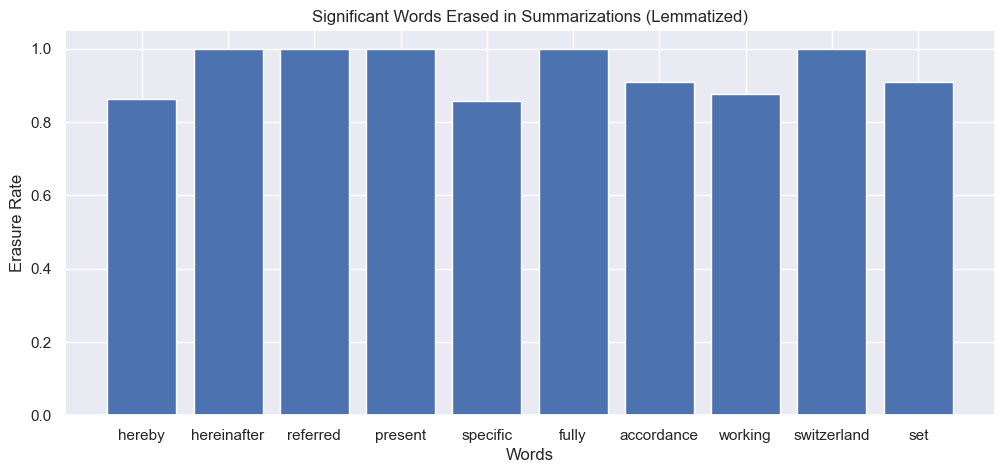

In [46]:
plt.figure(figsize=(12, 5))
plt.bar(significant_words_erased_lemma[:10], [erasure_rates_lemma[word] for word in significant_words_erased_lemma][:10])
plt.xlabel('Words')
plt.ylabel('Erasure Rate')
plt.title('Significant Words Erased in Summarizations (Lemmatized)')
plt.show()